## Group Project

## Importing the libraries

Let's import the necessary libraries to get started.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## The Data

Now we read the Heart Dataset into a dataframe.

In [2]:
heart_df = pd.read_csv('heart.dat', header=None, sep=" ")
heart_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


We now add the respective column names to the dataframe.

In [3]:
column_names = [
    "age",
    "sex",
    "cp_type",  # chest pain type
    "rest_bp",  # resting blood pressure
    "cholesterol",  # serum cholesterol in mg/dl
    "fast_bs",  # fasting blood sugar > 120 mg/dl
    "rest_ecg",  # resting electrocardiograph results
    "max_hr",  # maximum heart rate achieved
    "ex_angina",  # exercise induced angina
    "old_peak",  # old peak = ST depression induced by exercise relative to rest
    "slope",  # the slope of the peak exercise ST segment
    "num_vessels",  # number of major vessels colored by fluoroscopy
    "thal",  # thal: 3 = normal; 6 = fixed defect; 7 = reversible defect
    "hd_presence"  # heart disease presence
]

heart_df.columns = column_names
heart_df.head()

,age,sex,cp_type,rest_bp,cholesterol,fast_bs,rest_ecg,max_hr,ex_angina,old_peak,slope,num_vessels,thal,hd_presence
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [4]:
y = heart_df['hd_presence']
X = heart_df.drop('hd_presence', axis=1)

## ReliefF Feature Ranking

In [5]:
from skrebate import ReliefF

reliefF = ReliefF()

reliefF.fit(X.to_numpy(), y.to_numpy())
feature_scores = reliefF.feature_importances_

feature_rank_df = pd.DataFrame({
    'Feature': X.columns,
    'Score': feature_scores
})

feature_rank_df = feature_rank_df.sort_values(by='Score', ascending=False)
print(feature_rank_df)

        Feature     Score
12         thal  0.278481
11  num_vessels  0.174815
2       cp_type  0.171370
8     ex_angina  0.170926
10        slope  0.146741
9      old_peak  0.109763
7        max_hr  0.100883
1           sex  0.070333
0           age  0.036465
6      rest_ecg  0.022519
4   cholesterol  0.016005
3       rest_bp  0.007117
5       fast_bs -0.000444


## Fast Correlation-Based Filter (FCBF) Feature Ranking

In [6]:
from fcbf import fcbf

relevant_features, irrelevant_features, correlations = fcbf(X, y, su_threshold=0, base=2)
print('relevant_features:', relevant_features, '(count:', len(relevant_features), ')')
print('irrelevant_features:', irrelevant_features, '(count:', len(irrelevant_features), ')')
print('correlations:', correlations)

relevant_features: ['thal', 'cp_type', 'num_vessels', 'ex_angina', 'slope', 'rest_ecg'] (count: 6 )
irrelevant_features: ['fast_bs', 'age', 'rest_bp', 'sex', 'old_peak', 'max_hr', 'cholesterol'] (count: 7 )
correlations: {'thal': 0.1888023810360205, 'cp_type': 0.1416013911225963, 'num_vessels': 0.1371973858796752, 'ex_angina': 0.13634876704082757, 'slope': 0.09762728006147679, 'rest_ecg': 0.023604492346983152, 'fast_bs': 0.00024132042088733543, 'age': 0.050784796796006594, 'rest_bp': 0.05156329996334495, 'sex': 0.0704959014313005, 'old_peak': 0.09424607729730912, 'max_hr': 0.09924288899494042, 'cholesterol': 0.15297356642114715}


## Genetic Algorithm Test 1

In [7]:
import random
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from deap import creator, base, tools, algorithms
import warnings

warnings.filterwarnings('ignore')


def avg(l):
    """
    Returns the average between list elements
    """
    return sum(l) / float(len(l))


def get_fitness(individual, X, y):
    """
    Feature subset fitness function
    """

    if individual.count(0) != len(individual):
        # get index with value 0
        cols = [index for index in range(
            len(individual)) if individual[index] == 0]

        # get features subset
        X_parsed = X.drop(X.columns[cols], axis=1)
        X_subset = pd.get_dummies(X_parsed)

        # apply classification algorithm
        clf = MLPClassifier(random_state=1, max_iter=300)

        return (avg(cross_val_score(clf, X_subset, y, cv=2, scoring='accuracy', n_jobs=-1)),)
    else:
        return (0,)


def genetic_algorithm(X, y, n_population, n_generation):
    """
    Deap global variables
    Initialize variables to use eaSimple
    """
    # create individual
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # create toolbox
    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat,
                     creator.Individual, toolbox.attr_bool, len(X.columns))
    toolbox.register("population", tools.initRepeat, list,
                     toolbox.individual)
    toolbox.register("evaluate", get_fitness, X=X, y=y)
    toolbox.register("mate", tools.cxOnePoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)

    # initialize parameters
    pop = toolbox.population(n=n_population)
    hof = tools.HallOfFame(n_population * n_generation)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("min", np.min)
    stats.register("max", np.max)

    # genetic algorithm
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.2, mutpb=0.1,
                                   ngen=n_generation, stats=stats, halloffame=hof,
                                   verbose=True)

    # return hall of fame
    return hof


def best_individual(hof, X, y):
    """
    Get the best individual
    """
    for individual in hof:
        _individual = individual

    _individualHeader = [list(X)[i] for i in range(
        len(_individual)) if _individual[i] == 1]
    return _individual.fitness.values, _individual, _individualHeader


if __name__ == '__main__':
    # read dataframe from csv
    df = pd.read_csv('heart.dat', header=None, sep=" ")
    n_pop = 8
    n_gen = 8

    # encode labels column to numbers
    le = LabelEncoder()
    le.fit(df.iloc[:, -1])
    y = le.transform(df.iloc[:, -1])
    X = df.iloc[:, :-1]

    # get accuracy with all features
    individual = [1 for i in range(len(X.columns))]
    print("Accuracy with all features: \t" +
          str(get_fitness(individual, X, y)) + "\n")

    # apply genetic algorithm
    hof = genetic_algorithm(X, y, n_pop, n_gen)

    # select the best individual
    accuracy, individual, header = best_individual(hof, X, y)
    print('\n\nBest Accuracy: \t' + str(accuracy))
    print('Number of Features in Subset: \t' + str(individual.count(1)))
    print('Individual: \t\t' + str(individual))
    print('Feature Subset\t: ' + str(header))

    print('\n\nCreating a new classifier with the result')

    # read dataframe from csv one more time
    df = pd.read_csv('heart.dat', header=None, sep=" ")

    # with feature subset
    X = df[header]

    clf = MLPClassifier(random_state=1, max_iter=300)

    scores = cross_val_score(clf, X, y, cv=2, scoring='accuracy', n_jobs=-1)
    print("Accuracy with Feature Subset: \t" + str(avg(scores)) + "\n")

Accuracy with all features: 	(0.8222222222222222,)

gen	nevals	avg     	min     	max     
0  	8     	0.736574	0.555556	0.833333
1  	1     	0.769444	0.555556	0.833333
2  	2     	0.820833	0.803704	0.851852
3  	2     	0.826389	0.803704	0.82963 
4  	0     	0.82963 	0.82963 	0.82963 
5  	2     	0.794907	0.551852	0.82963 
6  	3     	0.805556	0.62963 	0.837037
7  	6     	0.832407	0.82963 	0.837037
8  	5     	0.837037	0.837037	0.837037


Best Accuracy: 	(0.5518518518518518,)
Number of Features in Subset: 	9
Individual: 		[1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0]
Feature Subset	: [0, 1, 3, 5, 7, 8, 9, 10, 11]


Creating a new classifier with the result
Accuracy with Feature Subset: 	0.5518518518518518



## Genetic Algorithm Test 2

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from random import randint
%matplotlib inline 
import warnings

warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split


def split(df, label):
    X_tr, X_te, Y_tr, Y_te = train_test_split(df, label, test_size=0.25, random_state=42)
    return X_tr, X_te, Y_tr, Y_te


from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold, cross_val_score

classifiers = ['LinearSVM', 'RadialSVM',
               'Logistic', 'RandomForest',
               'AdaBoost', 'DecisionTree',
               'KNeighbors', 'GradientBoosting']

models = [svm.SVC(kernel='linear'),
          svm.SVC(kernel='rbf'),
          LogisticRegression(max_iter=1000),
          RandomForestClassifier(n_estimators=200, random_state=0),
          AdaBoostClassifier(random_state=0),
          DecisionTreeClassifier(random_state=0),
          KNeighborsClassifier(),
          GradientBoostingClassifier(random_state=0)]


def acc_score(df, label):
    Score = pd.DataFrame({"Classifier": classifiers})
    j = 0
    acc = []
    X_train, X_test, Y_train, Y_test = split(df, label)
    for i in models:
        model = i
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        acc.append(accuracy_score(Y_test, predictions))
        j = j + 1
    Score["Accuracy"] = acc
    Score.sort_values(by="Accuracy", ascending=False, inplace=True)
    Score.reset_index(drop=True, inplace=True)
    return Score


def plot(score, x, y, c="b"):
    gen = [1, 2, 3, 4, 5]
    plt.figure(figsize=(6, 4))
    ax = sns.pointplot(x=gen, y=score, color=c)
    ax.set(xlabel="Generation", ylabel="Accuracy")
    ax.set(ylim=(x, y))

In [9]:
def initilization_of_population(size, n_feat):
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat, dtype='bool')
        chromosome[:int(0.3 * n_feat)] = False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population):
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:, chromosome], Y_train)
        predictions = logmodel.predict(X_test.iloc[:, chromosome])
        scores.append(accuracy_score(Y_test, predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds, :][::-1])


def selection(pop_after_fit, n_parents):
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):
    pop_nextgen = pop_after_sel
    for i in range(0, len(pop_after_sel), 2):
        new_par = []
        child_1, child_2 = pop_nextgen[i], pop_nextgen[i + 1]
        new_par = np.concatenate((child_1[:len(child_1) // 2], child_2[len(child_1) // 2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


def mutation(pop_after_cross, mutation_rate, n_feat):
    mutation_range = int(mutation_rate * n_feat)
    pop_next_gen = []
    for n in range(0, len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_posi = []
        for i in range(0, mutation_range):
            pos = randint(0, n_feat - 1)
            rand_posi.append(pos)
        for j in rand_posi:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen


def generations(df, label, size, n_feat, n_parents, mutation_rate, n_gen, X_train,
                X_test, Y_train, Y_test):
    best_chromo = []
    best_score = []
    population_nextgen = initilization_of_population(size, n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation', i + 1, ':', scores[:1])  #2
        pop_after_sel = selection(pop_after_fit, n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross, mutation_rate, n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])
    return best_chromo, best_score

In [10]:
data_bc = pd.read_csv("heart.dat", header=None, sep=" ")

column_names = [
    "age",
    "sex",
    "cp_type",  # chest pain type
    "rest_bp",  # resting blood pressure
    "cholesterol",  # serum cholesterol in mg/dl
    "fast_bs",  # fasting blood sugar > 120 mg/dl
    "rest_ecg",  # resting electrocardiograph results
    "max_hr",  # maximum heart rate achieved
    "ex_angina",  # exercise induced angina
    "old_peak",  # old peak = ST depression induced by exercise relative to rest
    "slope",  # the slope of the peak exercise ST segment
    "num_vessels",  # number of major vessels colored by fluoroscopy
    "thal",  # thal: 3 = normal; 6 = fixed defect; 7 = reversible defect
    "hd_presence"  # heart disease presence
]

data_bc.columns = column_names
data_bc.head()

,age,sex,cp_type,rest_bp,cholesterol,fast_bs,rest_ecg,max_hr,ex_angina,old_peak,slope,num_vessels,thal,hd_presence
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,2
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,1
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,2
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,1
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,1


In [11]:
label_bc = data_bc["hd_presence"]
# label_bc = np.where(label_bc == 'M', 1, 0)
data_bc.drop(["hd_presence"], axis=1, inplace=True)

print("Heart Disease dataset:\n", data_bc.shape[0], "Records\n", data_bc.shape[1], "Features")

Heart Disease dataset:
 270 Records
 13 Features


In [12]:
display(data_bc.head())
print("All the features in this dataset have continuous values")

,age,sex,cp_type,rest_bp,cholesterol,fast_bs,rest_ecg,max_hr,ex_angina,old_peak,slope,num_vessels,thal
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0


All the features in this dataset have continuous values


In [13]:
score1 = acc_score(data_bc, label_bc)
score1

,Classifier,Accuracy
0,LinearSVM,0.897059
1,Logistic,0.897059
2,AdaBoost,0.882353
3,RandomForest,0.852941
4,GradientBoosting,0.838235
5,DecisionTree,0.691176
6,RadialSVM,0.676471
7,KNeighbors,0.661765


In [14]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)

X_train, X_test, Y_train, Y_test = split(data_bc, label_bc)

chromo_df_bc, score_bc = generations(data_bc, label_bc, size=80, n_feat=data_bc.shape[1], n_parents=64,
                                     mutation_rate=0.20, n_gen=5,
                                     X_train=X_train, X_test=X_test, Y_train=Y_train, Y_test=Y_test)

Best score in generation 1 : [0.8529411764705882]
Best score in generation 2 : [0.8676470588235294]
Best score in generation 3 : [0.8823529411764706]
Best score in generation 4 : [0.8823529411764706]
Best score in generation 5 : [0.8823529411764706]


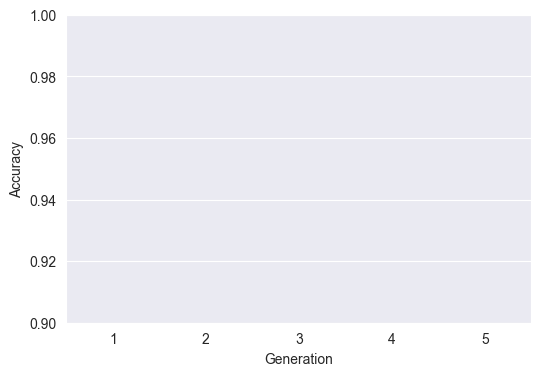

In [15]:
plot(score_bc, 0.9, 1.0, c="gold")